# Dynamic Routing Between Capsules

Link: https://arxiv.org/abs/1710.09829

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToTensor as tt
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets.mnist import MNIST

# Get matplotlib configuration
%run plot_conf.py

In [ ]:
def index_to_one_hot(index_tensor, num_classes=10):
    """
    Converts index value to one hot vector.

    e.g. [2, 5] (with 10 classes) becomes:
        [
            [0 0 1 0 0 0 0 0 0 0]
            [0 0 0 0 1 0 0 0 0 0]
        ]
    """
    index_tensor = index_tensor.long()
    return torch.eye(num_classes).index_select(dim=0, index=index_tensor)

## Squashing function

$$\boldsymbol{v}_j = {\lVert\boldsymbol{s}_j\rVert^2 \over 1 + \lVert\boldsymbol{s}_j\rVert^2} {\boldsymbol{s}_j \over \lVert\boldsymbol{s}_j\rVert}$$

In [ ]:
def squash_vector(tensor, dim=-1):
    """
    Non-linear 'squashing' to ensure short vectors get shrunk
    to almost zero length and long vectors get shrunk to a
    length slightly below 1.
    """
    squared_norm = (tensor**2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1 + squared_norm)
    return scale * tensor / torch.sqrt(squared_norm)

In [ ]:
def softmax(input, dim=1):
    """
    Apply softmax to specific dimensions. Not released on PyTorch stable yet
    as of 19th November 2017
    https://github.com/pytorch/pytorch/issues/3235
    """
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

In [20]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels,
                 kernel_size=None, stride=None, num_iterations=3):
        super().__init__()

        self.num_routes = num_routes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_routes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))

        else:
            self.capsules = nn.ModuleList([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0)
                for _ in range(num_capsules)
            ])

    def forward(self, x):
        # If routing is defined
        if self.num_routes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = Variable(torch.zeros(priors.size())).type_as(x)

            # Routing algorithm
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = squash_vector(probs * priors).sum(dim=2, keepdim=True)

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits

        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = squash_vector(outputs)

        return outputs

In [21]:
class CapsuleNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(8, -1, 256, 32, kernel_size=9, stride=2)

        # 10 is the number of classes
        self.digit_capsules = CapsuleLayer(10, 32 * 6 * 6, 8, 16)

        self.decoder = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5

        if y is None:
            # In all batches, get the most active capsule
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(10)).type_as(x).index_select(dim=0, index=max_length_indices.data)

        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return classes, reconstructions

## Margin loss

$$
\mathcal{L}_{k}^{(i)} =
\begin{cases}
\left[ \left( {m_+} - \lVert {\boldsymbol{v}_k^{(i)}} \rVert \right)^+ \right]^2,& \text{digit } {k} \text{ preset}\\
\lambda \left[ \left( \lVert {\boldsymbol{v}_k^{(i)}} \rVert - {m_-} \right)^+ \right]^2,& \text{otherwise}
\end{cases}
$$

$$
\mathcal{L}_\mu^{(i)} = \sum_{k}\mathcal{L}_{k}^{(i)}
$$

$$
\mathcal{L}^{(i)} = \mathcal{L}_\mu^{(i)} + \rho \cdot \mathcal{L}_\rho^{(i)}
$$

In [18]:
class MarginLoss(nn.Module):
    def __init__(self, m_plus=0.9, m_minus=0.1, rho=0.0005):
        super().__init__()
        self.m_plus = m_plus
        self.m_minus = m_minus
        self.rho = rho
        # Reconstruction as regularization
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, images, labels, classes, reconstructions):
        left = F.relu(self.m_plus - classes, inplace=True) ** 2
        right = F.relu(classes - self.m_minus, inplace=True) ** 2
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        return (margin_loss + self.rho * reconstruction_loss) / images.size(0)

<IPython.core.display.Javascript object>


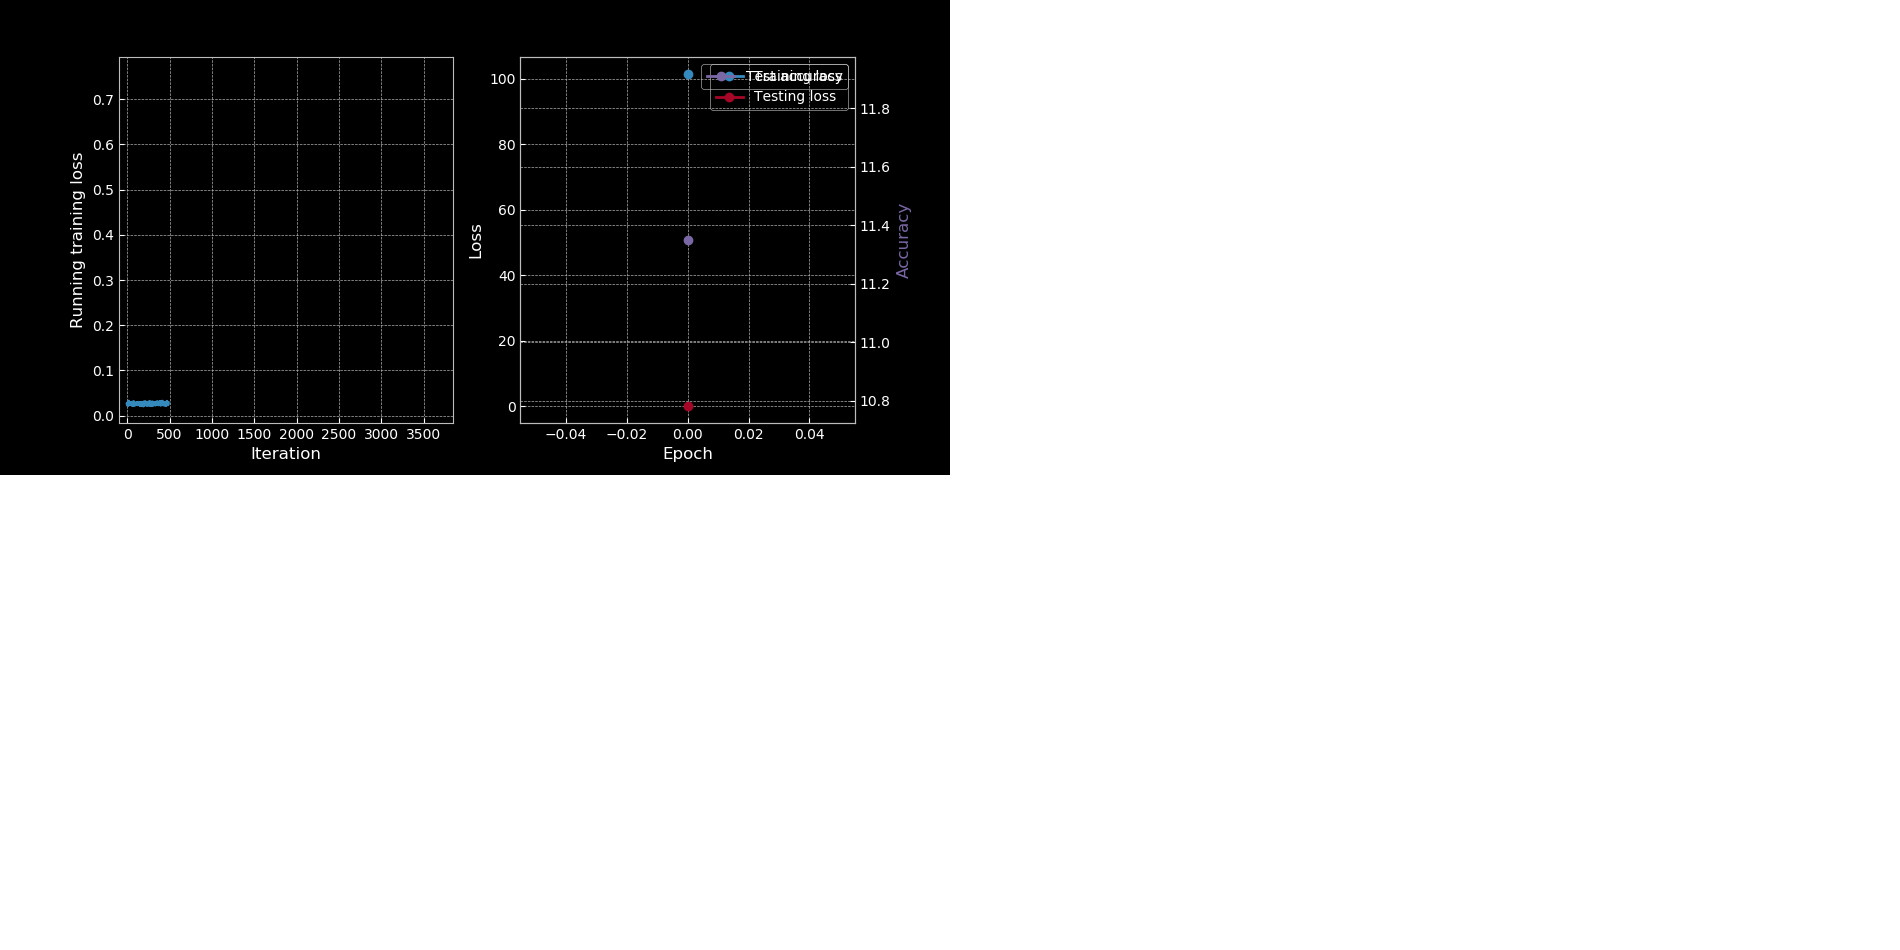

KeyboardInterrupt: 

In [ ]:
# Globals
CUDA = True
EPOCH = 10

# Model
model = CapsuleNet()

if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters())

margin_loss = MarginLoss()

train_MNIST  = MNIST(root='/tmp', train=True, download=True, transform=tt())
train_loader = DataLoader(train_MNIST, batch_size=16, shuffle=True)
test_MNIST   = MNIST(root='/tmp', train=False, download=True, transform=tt())
test_loader  = DataLoader(test_MNIST, batch_size=16, shuffle=True)

plt_interactive()

ax1 = plt.subplot(1, 2, 2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='C2')

ax = plt.subplot(1, 2, 1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Running training loss')
ax.set_xlim([-100, len(train_loader) + 100])

train_avg_loss = list()
test_avg_loss = list()
test_accuracy = list()
lines = None

for e in range(10):
    # Training
    train_loss_running = list()
    train_loss = 0

    model.train()
    for idx, (img, target) in enumerate(train_loader):
        img = Variable(img)
        target = Variable(index_to_one_hot(target))

        if CUDA:
            img = img.cuda()
            target = target.cuda()

        optimizer.zero_grad()

        classes, reconstructions = model(img, target)

        loss = margin_loss(img, target, classes, reconstructions)
        loss.backward()

        train_loss += loss.data.cpu()[0]

        optimizer.step()
        
        train_loss_running.append(loss.data[0])
        if lines: lines.pop(0).remove()
        lines, _ = ax.plot(train_loss_running, 'C0'), plt.gcf().canvas.draw()

#     print('Training:, Avg Loss: {:.4f}'.format(train_loss))
    train_avg_loss.append(train_loss)
    ax1.plot(train_avg_loss, '-oC0')

    # # Testing
    correct = 0
    test_loss = 0

    model.eval()
    for idx, (img, target) in enumerate(test_loader):
        img = Variable(img)
        target_index = target
        target = Variable(index_to_one_hot(target))

        if CUDA:
            img = img.cuda()
            target = target.cuda()

        classes, reconstructions = model(img, target)

        test_loss += margin_loss(img, target, classes, reconstructions).data.cpu()

        # Get index of the max log-probability
        pred = classes.data.max(1, keepdim=True)[1].cpu()
        correct += pred.eq(target_index.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    correct = 100. * correct / len(test_loader.dataset)
#     print('Test Set: Avg Loss: {:.4f}, Accuracy: {:.4f}'.format(test_loss[0], correct))
    test_avg_loss.append(test_loss[0])
    test_accuracy.append(correct)
    ax1.plot(test_avg_loss, '-oC1')
    ax2.plot(test_accuracy, '-oC2')
    ax1.legend(['Training loss', 'Testing loss'], loc=0)
    ax2.legend(['Test accuracy'], loc=1)